<a href="https://colab.research.google.com/github/sysbio-unam/practicas-computacionales-con-R/blob/main/intro_Grind.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Título: Introducción a Grind.R

Nombre: Biología de sistemas

Fecha: abril 2021

In [ ]:
# instalar librerías
install.packages("deSolve")
install.packages("FME")
install.packages("rootSolve")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# cargar Grind.R
source("Grind.R")

grind.R was sourced


Vamos a trabajar con el ejemplo del dímero cuya red se muestra en la Fig 1. 

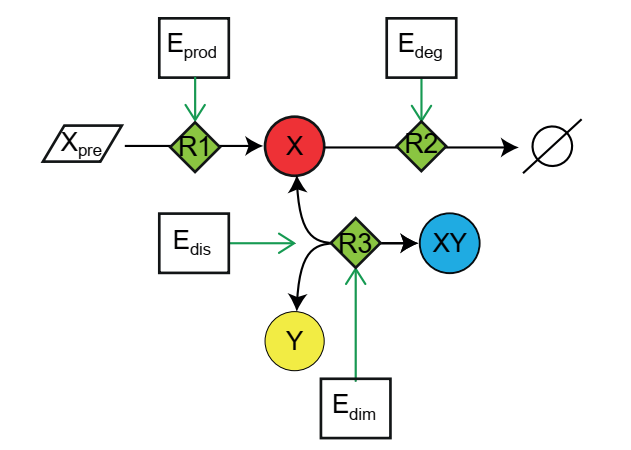

Figura 1. Red del proceso para el ejemplo del dímero

In [ ]:
# establecer modelo (Grind trabaja con el nombre del modelo "model" por default)
model <- function(time, state, parms) {
        with(as.list(c(state,parms)),{
                
                dx <- xpre*kprodEprod - x*kdegEdeg - x*y*kdimEdim + (ytot-y)*kdisEdis
                dy <- - x*y*kdimEdim + (ytot-y)*kdisEdis
                dxy <- - dy
                return(list(c(dx, dy, dxy)))
        })
}

In [ ]:
# declarar primer estimación para los parámetros
# (Grind trabaja con el nombre del vector de parámetros "p" por default)
p <- c(xpre = 10, kprodEprod = 0.5, kdegEdeg = 0.5, kdimEdim = 10, kdisEdis = 1, ytot = 6)

# Establecer condiciones iniciales (las cuales, efectivamente, son parámetros)
# (Grind trabaja con el nombre del vector de condiciones iniciales "s" por default)
s <- c(x = 0, y = 5, xy = 1)

x          y         xy 
6.23121864 0.09521706 5.90478294

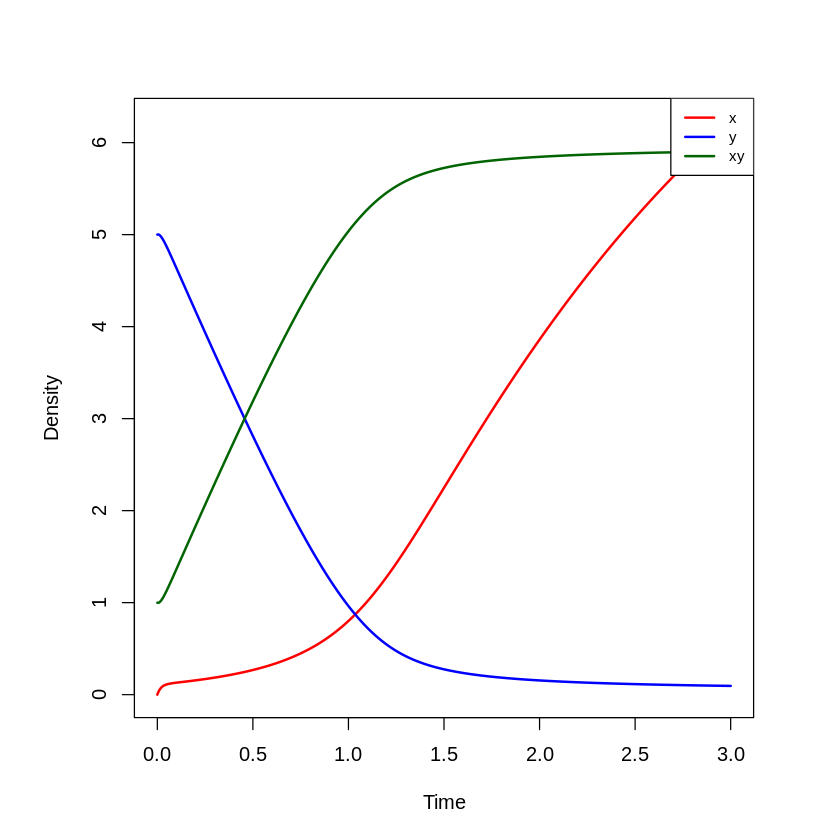

In [ ]:
# simulación numérica
par(pty="s") # axis square
run(parms=p, state = s, tstep=0.001, tmax=3)

## Optimización paramétrica 

La optimización paramétrica consiste en encontrar el conjunto de parámetros, $\vec{p}$, en el modelo que permiten tener la menor discrepancia entre los datos y la simulación hecha con el modelo. Este problema se puede establecer como siguie 

$
\text{Minimizar:} 
$
$$
\hspace{0.5cm} Costo(\vec{p}) = \sum_i^n \left(\vec{x}_{pred,i} - \vec{x}_{exp,i} \right)^2 
$$

$
\text{Sujeto a:}
$
$$
\frac{d\vec{x}(t)}{dt} = F(\vec{x(t)},\vec{p}) 
$$

$$
\hspace{1.5cm}\vec{x}(0) = \vec{x}_0
$$

Por lo tanto para la optimización paramétrica requerimos un conjunto de datos experimentales con observaciones de las variables en el modelo, en este caso $X$, $Y$ o $XY$

In [ ]:
# introducir datos experimentales
t_exp <- c(0, 1, 3, 6)
xy_exp <- c(0.5, 2.5, 3, 1.8)/0.5 
# guardar en un dataframe (necesario para usar la función fit()). 
# los nombres de las variables en el dataframe deben ser igual a sus nombres en el modelo
data <- data.frame(time = t_exp, xy = xy_exp)

SSR: 5.217441  Estimates:
kdimEdim     ytot 
194.4604 250.7686 


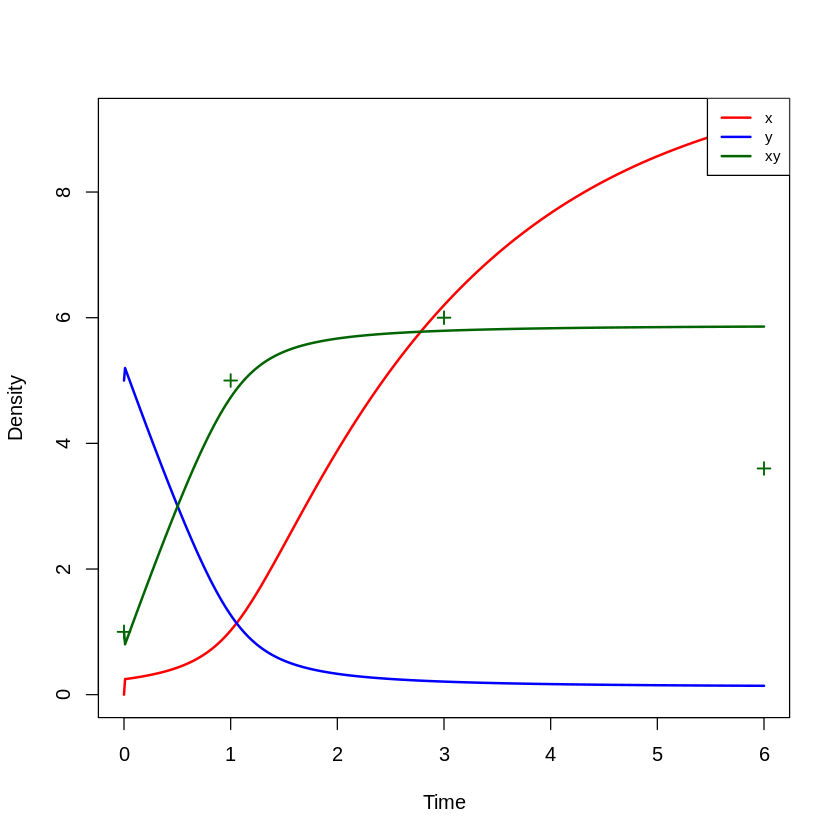

In [ ]:
# correr la optimización
w <- c("kdimEdim", "ytot") # w contiene los nombres de los parámetros libres
f <- fit(free = w, tstep = 0.01)

In [ ]:
# revisar error estándar, estadístico t, valor p, etc.
summary(f)


Parameters:
         Estimate Std. Error t value Pr(>|t|)
kdimEdim    194.5      222.8   0.873    0.475
ytot        250.8      290.3   0.864    0.479

Residual standard error: 1.615 on 2 degrees of freedom

Parameter correlation:
         kdimEdim    ytot
kdimEdim   1.0000 -0.9985
ytot      -0.9985  1.0000

In [ ]:
# es posible revisar los resultados del ejemplo con f$par
f$par

kdimEdim     ytot 
194.4604 250.7686

In [ ]:
# obtener la suma de los cuadrados del error
f$ssr

[1] 5.217441

In [ ]:
# los parámetros sin optimizar son
p

xpre kprodEprod   kdegEdeg   kdimEdim   kdisEdis       ytot 
      10.0        0.5        0.5       10.0        1.0        6.0

In [ ]:
# guardar un vector con los parámetros óptimos
p_opt=p
p_opt[4]=f$par[1]
p_opt[6]=f$par[2]
p_opt

xpre kprodEprod   kdegEdeg   kdimEdim   kdisEdis       ytot 
   10.0000     0.5000     0.5000   194.4604     1.0000   250.7686

x         y        xy 
6.1985687 0.2079205 5.7920795

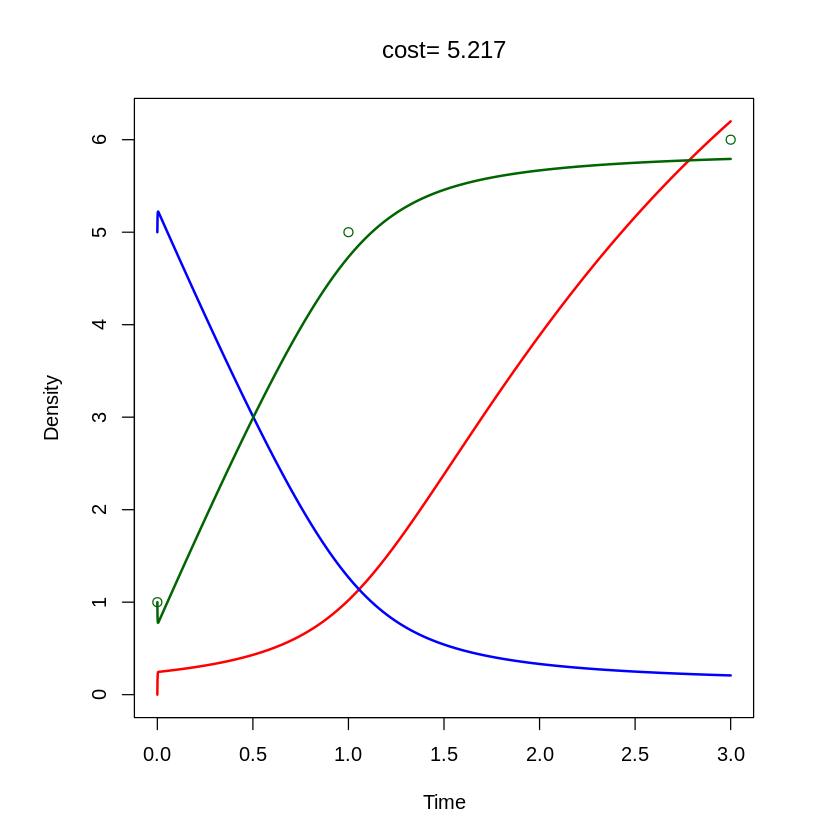

In [ ]:
# simular con los parámetros óptimos y comparar con los datos experimentales 
par(pty="s") # axis square
run(parms=p_opt, legend=FALSE, tstep=0.001, tmax=3, 
    main=c(paste("cost=", toString(round(f$ssr, digits = 3) ), sep=" ")))
points(t_exp, xy_exp, col="darkgreen", lty=5)